<a href="https://colab.research.google.com/github/aikios/SAToxPredictions/blob/main/training_reference_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.wildcardconsulting.dk/useful-information/molecular-neural-network-models-with-rdkit-and-keras-in-python/
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, MACCSkeys

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
#from sklearn.model_selection import cross_val_score
from sklearn import metrics

import pandas as pd
import numpy as np

import itertools
import math
import matplotlib.pyplot as plt
from scipy import stats

import pickle
import time

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Flatten, Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l1,l2

Using TensorFlow backend.


In [ ]:
#Read the data
#moe_data = pd.read_csv("M:\\ICCVAM\\clean_trainingset_MOE.csv")
# ! for pred
moe_data = pd.read_csv("M:\\ICCVAM\\predset_qsarr_2d_moe.csv")

In [ ]:
moe_data.columns[9:]

Index(['apol', 'ast_fraglike', 'ast_fraglike_ext', 'ast_violation',
       'ast_violation_ext', 'a_acc', 'a_acid', 'a_aro', 'a_base', 'a_count',
       ...
       'vsa_acid', 'vsa_base', 'vsa_don', 'vsa_hyd', 'vsa_other', 'vsa_pol',
       'Weight', 'weinerPath', 'weinerPol', 'zagreb'],
      dtype='object', length=206)

In [ ]:
# combine all moe numeric fingerprints
# ! check index
moe_numeric_param = moe_data.iloc[:,9:].select_dtypes(include=np.number).columns # 9 (pred) or 15 (train)

moe_data['moe_numeric_param'] = list(np.array(moe_data[moe_numeric_param]))
moe_data.drop(moe_numeric_param, axis=1, inplace=True)

In [ ]:
# add toxprints
#toxprints_df = pd.read_csv("Z:\\Desktop\\trainset.tsv", sep="\t")
toxprints_df = pd.read_csv("Z:\\Desktop\\predset.tsv", sep="\t")

In [ ]:
toxprints_df.columns[13:]

Index(['atom:element_main_group', 'atom:element_metal_group_I_II',
       'atom:element_metal_group_III', 'atom:element_metal_metalloid',
       'atom:element_metal_poor_metal', 'atom:element_metal_transistion_metal',
       'atom:element_noble_gas', 'bond:C#N_cyano_acylcyanide',
       'bond:C#N_cyano_cyanamide', 'bond:C#N_cyano_cyanohydrin',
       ...
       'ring:polycycle_spiro_[2.5]octane', 'ring:polycycle_spiro_[4.5]decane',
       'ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane',
       'ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene',
       'ring:polycycle_tricyclo_[3.7.7]bullvalene',
       'ring:polycycle_tricyclo_[3.7.7]semibullvalene',
       'ring:polycycle_tricyclo_adamantane',
       'ring:polycycle_tricyclo_benzvalene', 'M_COMPOUND_HISTORY_[STRING]',
       'M_CORINA_SYMPHONY_ERRORS_[STRING]'],
      dtype='object', length=731)

In [ ]:
toxprints_df['toxprint_fp'] = toxprints_df[list(toxprints_df.columns[18:-2])].values.tolist()
toxprints_df.drop(list(toxprints_df.columns[18:-2]), axis=1, inplace=True) # 13 pred, 18 train
columns_to_remove = list(toxprints_df.columns)
columns_to_remove.remove('toxprint_fp')
columns_to_remove.remove('Canonical_QSARr')
toxprints_df.drop(columns_to_remove, axis=1, inplace=True)

data = pd.merge(moe_data, toxprints_df, how='left', on=['Canonical_QSARr'])

In [ ]:
data.to_csv("M:\\ICCVAM\\long_data.csv")

In [ ]:
#create RDKit mol from smiles
mols = []
for i in range(len(data)):
    mol = Chem.MolFromSmiles(data.Canonical_QSARr[i])
    mols.append(mol)

data['Mol'] = mols

In [ ]:
# drop rows where SMILES does not create RDKit mol
index_no_mol = []
for i in range(len(data)):
    if str(type(data['Mol'][i])) != "<class 'rdkit.Chem.rdchem.Mol'>":
        index_no_mol.append(i)  
data.drop(data.index[index_no_mol], inplace=True)
data.reset_index(drop=True, inplace=True)

In [ ]:
data['Lipinski_NumHDonors'] = data['Mol'].apply(Chem.Lipinski.NumHDonors)
data['Lipinski_NumHAcceptors'] = data['Mol'].apply(Chem.Lipinski.NumHAcceptors)
data['Lipinski_NumHeteroatoms'] = data['Mol'].apply(Chem.Lipinski.NumHeteroatoms)
data['Lipinski_NumRotatableBonds'] = data['Mol'].apply(Chem.Lipinski.NumRotatableBonds)
data['Lipinski_NOCount'] = data['Mol'].apply(Chem.Lipinski.NOCount)
data['Lipinski_NHOHCount'] = data['Mol'].apply(Chem.Lipinski.NHOHCount)
data['Lipinski_RingCount'] = data['Mol'].apply(Chem.Lipinski.RingCount)
data['Lipinski_HeavyAtomCount'] = data['Mol'].apply(Chem.Lipinski.HeavyAtomCount)

In [ ]:
# create descriptors
#data['Molar_mass'] = data['Mol'].apply(Chem.Descriptors.MolWt)
data['NumValenceElectrons'] = data['Mol'].apply(Chem.Descriptors.NumValenceElectrons)
data['NumRadicalElectrons'] = data['Mol'].apply(Chem.Descriptors.NumRadicalElectrons)
data['TPSA'] = data['Mol'].apply(Chem.MolSurf.TPSA)

# create topological/topochemical descriptors
# http://www.rdkit.org/docs-beta/api/rdkit.Chem.GraphDescriptors-module.html
data['BalabanJ'] = data['Mol'].apply(Chem.GraphDescriptors.BalabanJ)
data['HallKierAlpha'] = data['Mol'].apply(Chem.GraphDescriptors.HallKierAlpha)
data['Ipc'] = data['Mol'].apply(Chem.GraphDescriptors.Ipc)
data['Kappa1'] = data['Mol'].apply(Chem.GraphDescriptors.Kappa1)
data['Kappa2'] = data['Mol'].apply(Chem.GraphDescriptors.Kappa2)
data['Kappa3'] = data['Mol'].apply(Chem.GraphDescriptors.Kappa3)
data['Chi0'] = data['Mol'].apply(Chem.GraphDescriptors.Chi0)
data['Chi1'] = data['Mol'].apply(Chem.GraphDescriptors.Chi1)
data['Chi0v'] = data['Mol'].apply(Chem.GraphDescriptors.Chi0v)
data['Chi1v'] = data['Mol'].apply(Chem.GraphDescriptors.Chi1v)
data['Chi2v'] = data['Mol'].apply(Chem.GraphDescriptors.Chi2v)
data['Chi3v'] = data['Mol'].apply(Chem.GraphDescriptors.Chi3v)
data['Chi4v'] = data['Mol'].apply(Chem.GraphDescriptors.Chi4v)
data['Chi0n'] = data['Mol'].apply(Chem.GraphDescriptors.Chi0n)
data['Chi1n'] = data['Mol'].apply(Chem.GraphDescriptors.Chi1n)
data['Chi2n'] = data['Mol'].apply(Chem.GraphDescriptors.Chi2n)
data['Chi3n'] = data['Mol'].apply(Chem.GraphDescriptors.Chi3n)
data['Chi4n'] = data['Mol'].apply(Chem.GraphDescriptors.Chi4n)
data['BertzCT'] = data['Mol'].apply(Chem.GraphDescriptors.BertzCT)

In [ ]:
molar_masses = []

for i in range(len(data)):
    mol = Chem.MolFromSmiles(data.Canonical_QSARr[i])
    molar_masses.append(Descriptors.MolWt(mol))
        
data['Molar_mass'] = molar_masses

In [ ]:
# cannot calc for pred

log_LD50_molkgs = []

for i in range(len(data)):
    LD50_mgkg = data['LD50_mgkg'][i]
    #molar_mass = moe_data['Weight'][i]
    molar_mass = data['Molar_mass'][i]
    log_LD50_molkg = np.log10(LD50_mgkg / (molar_mass * 1000.))
    log_LD50_molkgs.append(log_LD50_molkg)

data['log_LD50_molkg'] = log_LD50_molkgs

In [ ]:
data['PEOE_VSA1'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA1)
data['PEOE_VSA2'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA2)
data['PEOE_VSA3'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA3)
data['PEOE_VSA4'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA4)
data['PEOE_VSA5'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA5)
data['PEOE_VSA6'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA6)
data['PEOE_VSA7'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA7)
data['PEOE_VSA8'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA8)
data['PEOE_VSA9'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA9)
data['PEOE_VSA10'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA10)
data['PEOE_VSA11'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA11)
data['PEOE_VSA12'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA12)
data['PEOE_VSA13'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA13)
data['PEOE_VSA14'] = data['Mol'].apply(Chem.MolSurf.PEOE_VSA14)
data['SMR_VSA1'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA1)
data['SMR_VSA2'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA2)
data['SMR_VSA3'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA3)
data['SMR_VSA4'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA4)
data['SMR_VSA5'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA5)
data['SMR_VSA6'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA6)
data['SMR_VSA7'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA7)
data['SMR_VSA8'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA8)
data['SMR_VSA9'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA9)
data['SMR_VSA10'] = data['Mol'].apply(Chem.MolSurf.SMR_VSA10)
data['SlogP_VSA1'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA1)
data['SlogP_VSA2'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA2)
data['SlogP_VSA3'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA3)
data['SlogP_VSA4'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA4)
data['SlogP_VSA5'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA5)
data['SlogP_VSA6'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA6)
data['SlogP_VSA7'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA7)
data['SlogP_VSA8'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA8)
data['SlogP_VSA9'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA9)
data['SlogP_VSA10'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA10)
data['SlogP_VSA11'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA11)
data['SlogP_VSA12'] = data['Mol'].apply(Chem.MolSurf.SlogP_VSA12)

In [ ]:
Topologicals = []

for i in range(len(data)):
    mol = Chem.MolFromSmiles(data.Canonical_QSARr[i])
    Topologicals.append(Fingerprinter.FingerprintMol(mol)[0])

data['Topological'] = Topologicals

In [ ]:
data['MACCS'] = data['Mol'].apply(MACCSkeys.GenMACCSKeys)

In [ ]:
def EState(mol):
    fp = Chem.EState.Fingerprinter.FingerprintMol(mol)
    npfp = np.concatenate((fp[0], fp[1]))
    return npfp
data['EState'] = data['Mol'].apply(EState)

In [ ]:
def morgan_fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,3, nBits=8192)
    npfp = np.array(list(fp.ToBitString())).astype('float64')
    return npfp

data['Morgan3'] = data['Mol'].apply(morgan_fp)

In [ ]:
def atompair_fp(mol):
    fp = AllChem.GetHashedAtomPairFingerprintAsBitVect(mol)
    npfp = np.array(list(fp.ToBitString())).astype('float64')
    return npfp

data['AtomPair'] = data['Mol'].apply(atompair_fp)

In [ ]:
def morgan_fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=8192)
    npfp = np.array(list(fp.ToBitString())).astype('float64')
    return npfp

data['Morgan2'] = data['Mol'].apply(morgan_fp)

In [ ]:
def torsion_fp(mol):
    fp = AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)
    npfp = np.array(list(fp.ToBitString())).astype('float64')
    return npfp

data['Torsion'] = data['Mol'].apply(torsion_fp)

In [ ]:
data.sort_values(by='log_LD50_molkg', inplace=True)
log_LD50_molkg_lst = [x for x in data['log_LD50_molkg'].values if str(x) != 'nan']

In [ ]:
data.columns[12:]

Index(['Lipinski_NumHDonors', 'Lipinski_NumHAcceptors',
       'Lipinski_NumHeteroatoms', 'Lipinski_NumRotatableBonds',
       'Lipinski_NOCount', 'Lipinski_NHOHCount', 'Lipinski_RingCount',
       'Lipinski_HeavyAtomCount', 'NumValenceElectrons', 'NumRadicalElectrons',
       'TPSA', 'BalabanJ', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2',
       'Kappa3', 'Chi0', 'Chi1', 'Chi0v', 'Chi1v', 'Chi2v', 'Chi3v', 'Chi4v',
       'Chi0n', 'Chi1n', 'Chi2n', 'Chi3n', 'Chi4n', 'BertzCT', 'Molar_mass',
       'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
       'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'SMR_VSA1',
       'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7',
       'SMR_VSA8', 'SMR_VSA9', 'SMR_VSA10', 'SlogP_VSA1', 'SlogP_VSA2',
       'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
       'SlogP_VSA8', 'SlogP_VSA9', 'SlogP_VSA10', 'Slog

In [ ]:
# ! exclude ld50 column in train set
rdkit_numeric_param = list(data.iloc[:,12:].select_dtypes(include=np.number).columns) # 16 in train, 12 in pred
#rdkit_numeric_param.remove('log_LD50_molkg')
data['rdkit_numeric_param'] = list(np.array(data[rdkit_numeric_param]))
data.drop(rdkit_numeric_param, axis=1, inplace=True)

In [ ]:
len(data)

60147

In [ ]:
# skip for pred
def normalize(val, lst):
    n = (val - min(lst)) / (max(lst) - min(lst))
    return n

scaled_LD50 = [normalize(x, log_LD50_molkg_lst) for x in log_LD50_molkg_lst]
data['scaled_ld50'] = scaled_LD50
y = scaled_LD50
this_mean = sum(y)/len(y)
y_mean = [this_mean for x in scaled_LD50]

# this is the number to beat
rms= math.sqrt(metrics.mean_squared_error(y, y_mean))
print(rms) # should be 0.120305

0.1203050049815286


In [ ]:
lst = ['moe_numeric_param', 'toxprint_fp', 'Topological', 'MACCS','EState', 'rdkit_numeric_param']
#lst = data.columns[15:-1].tolist()
#lst.remove('log_LD50_molkg')
#lst.remove('Mol')

In [ ]:
# adds an epsilon to duplicate LD50 values for differentiation later
with_LD50 = data[data.log_LD50_molkg.notnull()].reset_index(drop=True) #.drop_duplicates(subset=['CASRN', "scaled_ld50"])
dup_ld50_rows = list(with_LD50[with_LD50.duplicated(subset='scaled_ld50') == True].index)

final_ld50 = []
for i in range(len(with_LD50)):
    if i in dup_ld50_rows:
        final_ld50.append(with_LD50['scaled_ld50'][i] + 0.000000001)
    else:
        final_ld50.append(with_LD50['scaled_ld50'][i])

with_LD50['final'] = final_ld50

In [ ]:
# to remove duplicates - can be placed in a while loop while len(dup) > 0
final_ld50 = []
for i in range(len(with_LD50)):
    if i in dup_ld50_rows:
        final_ld50.append(with_LD50['final'][i] + 0.000000001)
    else:
        final_ld50.append(with_LD50['final'][i])

with_LD50['final'] = final_ld50

dup_ld50_rows = list(with_LD50[with_LD50.duplicated(subset='final') == True].index)
print(len(dup_ld50_rows))
#print(len(final_ld50), len(with_LD50))

0


In [ ]:
my_y = with_LD50['final'].values

# separate into test and training
X_train_all_fp, X_test_all_fp, y_train, y_test = model_selection.train_test_split(with_LD50, my_y, test_size=0.25)

In [ ]:
with_LD50.head()

,MOE_mol,CASRN,DTXSID,Canonical_QSARr,DTXCID,Name,Structure_Source,Salt_Solvent,InChI_Code_QSARr,InChI Key_QSARr,...,moe_numeric_param,toxprint_fp,Mol,log_LD50_molkg,Topological,MACCS,EState,rdkit_numeric_param,scaled_ld50,final
0,O(C)c1c(OC)cc2c(C(CC3C(CC)CN4C(c5c(cc(OC)c(OC)...,316-42-7,DTXSID7020558,CCC1CN2CCC3C=C(OC)C(=CC=3C2CC1CC1NCCC2=CC(OC)=...,DTXCID90558,Emetine dihydrochloride,EPA_DSSTox,Cl.Cl,InChI=1S/C29H40N2O4/c1-6-18-17-31-10-8-20-14-2...,AUVVAXYIELKVAI-UHFFFAOYSA-N,...,"[83.11972, 0.0, 0.0, 3.0, 4.0, 6.0, 0.0, 12.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000190469...,-7.602647,"[0, 0, 0, 0, 0, 0, 5, 0, 8, 0, 0, 4, 4, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 8.0, ...","[1.0, 6.0, 6.0, 7.0, 6.0, 1.0, 5.0, 35.0, 190....",0.000000,0.000000
1,Clc1c(Cl)cc2Oc3c(Oc2c1)cc(Cl)c(Cl)c3,1746-01-6,DTXSID2021315,ClC1=CC2OC3C=C(Cl)C(Cl)=CC=3OC=2C=C1Cl,DTXCID001315,2 3 7 8-Tetrachlorodibenzo-p-dioxin,EPA_DSSTox,?,InChI=1S/C12H4Cl4O2/c13-5-1-9-10(2-6(5)14)18-1...,HGUFODBRKLSHSI-UHFFFAOYSA-N,...,"[34.111172, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 12.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x0000019052F...,-7.206791,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.0, 6.0, 0.0, 2.0, 0.0, 3.0, 18.0, 92.0...",0.053959,0.053959
2,FC(F)(F)C(O)(C(F)(F)F)CCCC(C)C1C2(C)C(/C(=C\C=...,83805-11-2,NaN,CC12CCCC(=CC=C3CC(O)CC(O)C3=C)C1CCC2C(C)CCCC(O...,NaN,NaN,Public_CrossChecked,?,InChI=1S/C27H38F6O3/c1-16(6-4-13-25(36 26(28 2...,XPYGGHVSFMUHLH-UHFFFAOYSA-N,...,"[78.606133, 0.0, 0.0, 2.0, 3.0, 3.0, 0.0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x0000019045F...,-7.099681,"[0, 0, 0, 0, 0, 0, 2, 1, 10, 0, 2, 0, 5, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 10.0,...","[3.0, 3.0, 9.0, 6.0, 3.0, 3.0, 3.0, 36.0, 206....",0.068559,0.068559
3,Brc1c(Br)cc2Oc3c(Oc2c1)cc(Br)c(Br)c3,50585-41-6,DTXSID6073524,BrC1C=C2OC3C=C(Br)C(Br)=CC=3OC2=CC=1Br,DTXCID3040855,2 3 7 8-Tetrabromodibenzo-p-dioxin,EPA_DSSTox,?,InChI=1S/C12H4Br4O2/c13-5-1-9-10(2-6(5)14)18-1...,JZLQUWSWOJPCAK-UHFFFAOYSA-N,...,"[37.591171, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 12.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000191AD4...,-6.698777,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.0, 6.0, 0.0, 2.0, 0.0, 3.0, 18.0, 92.0...",0.123206,0.123206
4,Brc1ccc(-c2ccc(C3CC(C=4C(=O)Oc5c(C=4O)cccc5)c4...,56073-10-0,DTXSID5032529,OC1=C(C2CC(CC3C=CC=CC=32)C2C=CC(=CC=2)C2C=CC(B...,DTXCID3012529,Brodifacoum,EPA_DSSTox,?,InChI=1S/C31H23BrO3/c32-24-15-13-20(14-16-24)1...,VEUZZDOCACZPRY-UHFFFAOYSA-N,...,"[75.352242, 0.0, 0.0, 2.0, 3.0, 2.0, 0.0, 24.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",<rdkit.Chem.rdchem.Mol object at 0x00000191DAC...,-6.514735,"[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 16, 2, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...","[1.0, 3.0, 4.0, 3.0, 3.0, 1.0, 6.0, 35.0, 172....",0.148293,0.148293


In [ ]:
hopefully_final = []
duds = []

In [ ]:
from keras.models import load_model

def sweep_PCA(item, epoch_size, batch_size, optim, hidden_dim, output_fxn, activation, loss_fxn):
#    m = 1 # output neurons
#    N = len(X_train) # training set size
#    hidden_dim = int(2 * math.sqrt((m + 2) * N))
    print(item,epoch_size, batch_size, optim, hidden_dim, output_fxn, activation, loss_fxn)
    model = None
    try:
        X_train = np.array(list(X_train_all_fp[item])) #(list(with_LD50[item]))
        X_test = np.array(list(X_test_all_fp[item])) 
    #        except:
    #            make_2D = np.reshape(np.array(list(data[data.log_LD50_molkg.notnull()][item])), (-1,1))
    #            X = make_2D
    #    y = scaled_LD50 #log_LD50_molkg_lst

        #Scale X to unit variance and zero mean
        st = StandardScaler()
        try:
            try:
                X_train = st.fit_transform(X_train)
                X_test = st.fit_transform(X_test)
            except:
                reshape = np.reshape(X_train, (-1,1))
                X_train = st.fit_transform(reshape)
                
                reshape = np.reshape(X_test, (-1,1))
                X_test = st.fit_transform(reshape)

            # standardize?
            #these_vals = []
#            kf = model_selection.KFold(n_splits=10)
#            X = with_LD50[item]
#            try:
#                X = st.fit_transform(X)
#            except:
#                reshape = np.reshape(X, (-1,1))
#                X = st.fit_transform(reshape)       
                      
#            for train,test in kf.split(X):
#                X_train, X_test, y_train, y_test =  X[train], X[test], y[train], y[test]

            model = Sequential()
            model.add(Dense(input_dim=X_train.shape[1], units=hidden_dim))#units=5))
            #model.add(Dropout (0.2))
            model.add(Activation(activation)) #"relu"
            model.add(Dense(units=1))
            model.add(Activation(output_fxn)) #"linear"
            # add line to stop if loss is negative

            model.compile(loss=loss_fxn, optimizer=optim)#'mean_squared_error', Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
            stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
            reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
            history = model.fit(np.array(X_train), np.array(y_train), epochs=epoch_size, batch_size=batch_size, verbose=1, callbacks=[stop, reduce_lr])

            test_pred = model.predict(X_test)
            train_pred = model.predict(X_train)
            model.save(item+'_final_LD50_feb16.h5')
            model.save_weights(item+'_final_LD50_feb16_weights.h5')
            # add constraints model.add(Dense(64, kernel_constraint=max_norm(2.)))
            #http://pubs.acs.org/doi/pdf/10.1021/acs.jcim.6b00088, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4530125/

            rms_test = math.sqrt(metrics.mean_squared_error(y_test, test_pred))     # hopefully rms < 0.12196980916781124    
            rms_train = math.sqrt(metrics.mean_squared_error(y_train, train_pred))
            q2 = metrics.r2_score(y_train, train_pred)
            r2 = metrics.r2_score(y_test, test_pred)
            rho = stats.spearmanr(y_test, test_pred)
            hopefully_final.append((item, epoch_size, batch_size, optim, hidden_dim,
                                      output_fxn, activation, loss_fxn, rms_test, rms_train, q2, r2,
                                      rho, y_train, train_pred, y_test, test_pred, X_train, X_test))
        except:
            print('Try reshaping ' + item)
            
    except:
        duds.append((item, epoch_size, batch_size, optim, hidden_dim,
                              output_fxn, activation, loss_fxn, rms, q2, r2,
                              rho, y_train, train_pred, y_test, test_pred))

In [ ]:
class WindowsInhibitor:
    '''Prevent OS sleep/hibernate in windows; code from:
    https://github.com/h3llrais3r/Deluge-PreventSuspendPlus/blob/master/preventsuspendplus/core.py
    API documentation:
    https://msdn.microsoft.com/en-us/library/windows/desktop/aa373208(v=vs.85).aspx'''
    ES_CONTINUOUS = 0x80000000
    ES_SYSTEM_REQUIRED = 0x00000001

    def __init__(self):
        pass

    def inhibit(self):
        import ctypes
        print("Preventing Windows from going to sleep")
        ctypes.windll.kernel32.SetThreadExecutionState(
            WindowsInhibitor.ES_CONTINUOUS | \
            WindowsInhibitor.ES_SYSTEM_REQUIRED)

    def uninhibit(self):
        import ctypes
        print("Allowing Windows to go to sleep")
        ctypes.windll.kernel32.SetThreadExecutionState(
            WindowsInhibitor.ES_CONTINUOUS)


In [ ]:
import os

osSleep = None
# in Windows, prevent the OS from sleeping while we run
if os.name == 'nt':
    osSleep = WindowsInhibitor()
    osSleep.inhibit()

sweep_PCA('moe_numeric_param', 2000,42,'Adagrad',245,'sigmoid','softsign','binary_crossentropy')
sweep_PCA('MACCS', 2000,43,'Adagrad',245,'sigmoid','softsign','binary_crossentropy')
sweep_PCA('rdkit_numeric_param', 2000,60,'Adadelta',245,'hard_sigmoid','softsign','mean_absolute_error')
sweep_PCA('toxprint_fp', 2000,46,'SGD',245,'hard_sigmoid','softsign','binary_crossentropy')
sweep_PCA('Topological', 2000,54, 'SGD',245,'sigmoid','softsign','mean_absolute_error')
sweep_PCA('EState', 2000,43, 'SGD',245,'hard_sigmoid','softsign','binary_crossentropy')

if osSleep:
    osSleep.uninhibit() 

Preventing Windows from going to sleep
moe_numeric_param 2000 42 Adagrad 245 sigmoid softsign binary_crossentropy
Epoch 1/2000
5745/5745 [==============================] - 1s 184us/step - loss: 0.6355
Epoch 2/2000
5745/5745 [==============================] - 0s 58us/step - loss: 0.6069
Epoch 3/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.6035
Epoch 4/2000
5745/5745 [==============================] - 0s 58us/step - loss: 0.6015
Epoch 5/2000
5745/5745 [==============================] - 0s 58us/step - loss: 0.5999
Epoch 6/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5990
Epoch 7/2000
5745/5745 [==============================] - 0s 58us/step - loss: 0.5985
Epoch 8/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5978
Epoch 9/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5973
Epoch 10/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5969
Epoch 11/2000
5745/5745 

Epoch 94/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5879
Epoch 95/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5879
Epoch 96/2000
5745/5745 [==============================] - 0s 59us/step - loss: 0.5879
Epoch 97/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5878
Epoch 98/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5877
Epoch 99/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5877
Epoch 100/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5877
Epoch 101/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5877
Epoch 102/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5876
Epoch 103/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5876
Epoch 104/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5876
Epoch 105/2000
5745/5745 [============

5745/5745 [==============================] - 0s 57us/step - loss: 0.5859
Epoch 188/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5859
Epoch 189/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5859
Epoch 190/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5859
Epoch 191/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5859
Epoch 192/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5858
Epoch 193/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5859
Epoch 194/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5858
Epoch 195/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5858
Epoch 196/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5858
Epoch 197/2000
5745/5745 [==============================] - 0s 57us/step - loss: 0.5858
Epoch 198/2000
5745/5745 [=====================

C:\Users\rsayre01\Continuum\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/2000
5745/5745 [==============================] - 1s 167us/step - loss: 0.6239
Epoch 2/2000
5745/5745 [==============================] - 0s 54us/step - loss: 0.6024
Epoch 3/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.6000
Epoch 4/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5985
Epoch 5/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5975
Epoch 6/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5966
Epoch 7/2000
5745/5745 [==============================] - 0s 54us/step - loss: 0.5958
Epoch 8/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5951
Epoch 9/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5947
Epoch 10/2000
5745/5745 [==============================] - 0s 54us/step - loss: 0.5941
Epoch 11/2000
5745/5745 [==============================] - 0s 54us/step - loss: 0.5937
Epoch 12/2000
5745/5745 [==========================

5745/5745 [==============================] - 0s 54us/step - loss: 0.5858
Epoch 96/2000
5745/5745 [==============================] - 0s 54us/step - loss: 0.5858
Epoch 97/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5857
Epoch 98/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5858
Epoch 99/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5857
Epoch 100/2000
5745/5745 [==============================] - 0s 54us/step - loss: 0.5857
Epoch 101/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5857
Epoch 102/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5857
Epoch 103/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5856
Epoch 104/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5856
Epoch 105/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5856
Epoch 106/2000
5745/5745 [=========================

5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 189/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 190/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 191/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 192/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 193/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 194/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 195/2000
5745/5745 [==============================] - 0s 54us/step - loss: 0.5849
Epoch 196/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 197/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 198/2000
5745/5745 [==============================] - 0s 55us/step - loss: 0.5849
Epoch 199/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 38us/step - loss: 0.0507
Epoch 79/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0506
Epoch 80/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0506
Epoch 81/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0504
Epoch 82/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0510
Epoch 83/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0500
Epoch 84/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0505
Epoch 85/2000
5745/5745 [==============================] - 0s 38us/step - loss: 0.0506
Epoch 86/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0500
Epoch 87/2000
5745/5745 [==============================] - 0s 38us/step - loss: 0.0498
Epoch 88/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0495
Epoch 89/2000
5745/5745 [==============================] 

5745/5745 [==============================] - 0s 37us/step - loss: 0.0417
Epoch 172/2000
5745/5745 [==============================] - 0s 38us/step - loss: 0.0414
Epoch 173/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0410
Epoch 174/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0411
Epoch 175/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0417
Epoch 176/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0404
Epoch 177/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0413
Epoch 178/2000
5745/5745 [==============================] - 0s 38us/step - loss: 0.0411
Epoch 179/2000
5745/5745 [==============================] - 0s 38us/step - loss: 0.0414
Epoch 180/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0402
Epoch 181/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0402
Epoch 182/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 64us/step - loss: 0.5994
Epoch 49/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5993
Epoch 50/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5993
Epoch 51/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5992
Epoch 52/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5991
Epoch 53/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5991
Epoch 54/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5990
Epoch 55/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5989
Epoch 56/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5989
Epoch 57/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5988
Epoch 58/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5988
Epoch 59/2000
5745/5745 [==============================] 

5745/5745 [==============================] - 0s 63us/step - loss: 0.5953
Epoch 142/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5953
Epoch 143/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5952
Epoch 144/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5952
Epoch 145/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5952
Epoch 146/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5951
Epoch 147/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5951
Epoch 148/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5951
Epoch 149/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5950
Epoch 150/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5950
Epoch 151/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5950
Epoch 152/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 63us/step - loss: 0.5926
Epoch 235/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5926
Epoch 236/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5925
Epoch 237/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5925
Epoch 238/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5925
Epoch 239/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5925
Epoch 240/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5924
Epoch 241/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5924
Epoch 242/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5924
Epoch 243/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5924
Epoch 244/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5923
Epoch 245/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 63us/step - loss: 0.5906
Epoch 328/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5906
Epoch 329/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5905
Epoch 330/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5905
Epoch 331/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5905
Epoch 332/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5905
Epoch 333/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5905
Epoch 334/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5904
Epoch 335/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5904
Epoch 336/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5904
Epoch 337/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5904
Epoch 338/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 64us/step - loss: 0.5891
Epoch 421/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5891
Epoch 422/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5891
Epoch 423/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5891
Epoch 424/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5891
Epoch 425/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5891
Epoch 426/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5891
Epoch 427/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5891
Epoch 428/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5890
Epoch 429/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5890
Epoch 430/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5890
Epoch 431/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 514/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 515/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 516/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5881
Epoch 517/2000
5745/5745 [==============================] - 0s 64us/step - loss: 0.5881
Epoch 518/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 519/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 520/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 521/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 522/2000
5745/5745 [==============================] - 0s 63us/step - loss: 0.5881
Epoch 523/2000
5745/5745 [==============================] - 1s 91us/step - loss: 0.5881
Epoch 524/2000
5745/5745 [=====================

Epoch 30/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0741
Epoch 31/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0740
Epoch 32/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0740
Epoch 33/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0739
Epoch 34/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0738
Epoch 35/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0737
Epoch 36/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0736
Epoch 37/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0735
Epoch 38/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0734
Epoch 39/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0733
Epoch 40/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0732
Epoch 41/2000
5745/5745 [==================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0682
Epoch 124/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0681
Epoch 125/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0681
Epoch 126/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0680
Epoch 127/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0680
Epoch 128/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0679
Epoch 129/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0679
Epoch 130/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0678
Epoch 131/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0678
Epoch 132/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0677
Epoch 133/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0677
Epoch 134/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0639
Epoch 217/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0639
Epoch 218/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0638
Epoch 219/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0638
Epoch 220/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0638
Epoch 221/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0637
Epoch 222/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0637
Epoch 223/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0636
Epoch 224/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0636
Epoch 225/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0635
Epoch 226/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0635
Epoch 227/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0601
Epoch 310/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0601
Epoch 311/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0600
Epoch 312/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0600
Epoch 313/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0600
Epoch 314/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0600
Epoch 315/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0599
Epoch 316/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0599
Epoch 317/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0598
Epoch 318/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0598
Epoch 319/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0598
Epoch 320/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0568
Epoch 403/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0567
Epoch 404/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0567
Epoch 405/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0567
Epoch 406/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0567
Epoch 407/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0566
Epoch 408/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0566
Epoch 409/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0566
Epoch 410/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0565
Epoch 411/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0565
Epoch 412/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0564
Epoch 413/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0539
Epoch 496/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0538
Epoch 497/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0539
Epoch 498/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0538
Epoch 499/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0538
Epoch 500/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0537
Epoch 501/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0537
Epoch 502/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0536
Epoch 503/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0536
Epoch 504/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0536
Epoch 505/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0536
Epoch 506/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0513
Epoch 589/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0513
Epoch 590/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0513
Epoch 591/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0513
Epoch 592/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0512
Epoch 593/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0512
Epoch 594/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0512
Epoch 595/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0512
Epoch 596/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0511
Epoch 597/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0511
Epoch 598/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0511
Epoch 599/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 37us/step - loss: 0.0492
Epoch 682/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0492
Epoch 683/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0491
Epoch 684/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0491
Epoch 685/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0491
Epoch 686/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0491
Epoch 687/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0490
Epoch 688/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0490
Epoch 689/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0491
Epoch 690/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0490
Epoch 691/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0489
Epoch 692/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0473
Epoch 775/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0472
Epoch 776/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0472
Epoch 777/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0472
Epoch 778/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0472
Epoch 779/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0472
Epoch 780/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0472
Epoch 781/2000
5745/5745 [==============================] - 0s 37us/step - loss: 0.0471
Epoch 782/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0471
Epoch 783/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0471
Epoch 784/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0471
Epoch 785/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0456
Epoch 868/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0456
Epoch 869/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0456
Epoch 870/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0455
Epoch 871/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0455
Epoch 872/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0455
Epoch 873/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0455
Epoch 874/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0455
Epoch 875/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0454
Epoch 876/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0455
Epoch 877/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0454
Epoch 878/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 36us/step - loss: 0.0441
Epoch 961/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0441
Epoch 962/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0440
Epoch 963/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0440
Epoch 964/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0440
Epoch 965/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0440
Epoch 966/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0440
Epoch 967/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0439
Epoch 968/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0440
Epoch 969/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0439
Epoch 970/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0438
Epoch 971/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1053/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1054/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1055/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1056/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1057/2000
5745/5745 [==============================] - 0s 36us/step - loss: 0.0431
Epoch 1058/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1059/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1060/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1061/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
Epoch 1062/2000
5745/5745 [==============================] - 0s 35us/step - loss: 0.0431
EState 2000 43 SGD 245 hard_sigmoid s

5745/5745 [==============================] - 0s 52us/step - loss: 0.6038
Epoch 84/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6038
Epoch 85/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6038
Epoch 86/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6037
Epoch 87/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6037
Epoch 88/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6037
Epoch 89/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6037
Epoch 90/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6036
Epoch 91/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6036
Epoch 92/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6036
Epoch 93/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6035
Epoch 94/2000
5745/5745 [==============================] 

5745/5745 [==============================] - 0s 52us/step - loss: 0.6016
Epoch 177/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6016
Epoch 178/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6016
Epoch 179/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6016
Epoch 180/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6015
Epoch 181/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6015
Epoch 182/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6015
Epoch 183/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6015
Epoch 184/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6015
Epoch 185/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6014
Epoch 186/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6014
Epoch 187/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 52us/step - loss: 0.6000
Epoch 270/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6000
Epoch 271/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6000
Epoch 272/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6000
Epoch 273/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6000
Epoch 274/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.6000
Epoch 275/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5999
Epoch 276/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5999
Epoch 277/2000
5745/5745 [==============================] - 0s 53us/step - loss: 0.5999
Epoch 278/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5999
Epoch 279/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5999
Epoch 280/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 363/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 364/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 365/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 366/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 367/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 368/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 369/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5987
Epoch 370/2000
5745/5745 [==============================] - 0s 53us/step - loss: 0.5986
Epoch 371/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5986
Epoch 372/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5986
Epoch 373/2000
5745/5745 [=====================

5745/5745 [==============================] - 0s 52us/step - loss: 0.5977
Epoch 455/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5977
Epoch 456/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5977
Epoch 457/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976
Epoch 458/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976
Epoch 459/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976
Epoch 460/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976
Epoch 461/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976: 0s - loss: 0.
Epoch 462/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976
Epoch 463/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976
Epoch 464/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5976: 0s - loss: 0.5
Epoch 465/2000
5

5745/5745 [==============================] - 0s 52us/step - loss: 0.5968
Epoch 547/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5968
Epoch 548/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 549/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 550/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 551/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 552/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 553/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 554/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 555/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 556/2000
5745/5745 [==============================] - 0s 52us/step - loss: 0.5967
Epoch 557/2000
5745/5745 [=====================

In [ ]:
# for all above threshold - use a loop
correct_tts_df = pd.DataFrame(hopefully_final, columns = ['item', 'epoch_size', 'batch_size', 'optim', 'hidden_dim',
                                      'output_fxn', 'activation', 'loss_fxn', 'rms_test', 'rms_train', 'q2', 'r2',
                                      'rho', 'y_train', 'train_pred', 'y_test', 'test_pred', 'X_train', 'X_test']) #hopefully_final_df.ix[[0,3,9,2,4,1]]
correct_tts_df

,item,epoch_size,batch_size,optim,hidden_dim,output_fxn,activation,loss_fxn,rms_test,rms_train,q2,r2,rho,y_train,train_pred,y_test,test_pred,X_train,X_test
0,moe_numeric_param,2000,42,Adagrad,245,sigmoid,softsign,binary_crossentropy,0.083908,0.030726,0.934226,0.525247,"(0.713822320015, 2.93496731741e-298)","[0.896694752908, 0.764355266053, 0.84372511237...","[[0.862467], [0.774727], [0.811651], [0.489713...","[0.714784683907, 0.750056632064, 0.78986378928...","[[0.735465], [0.746015], [0.756783], [0.785442...","[[-0.048290058713, -0.931822237837, -0.6955065...","[[0.879335212906, -0.946593684725, -0.71849230..."
1,MACCS,2000,43,Adagrad,245,sigmoid,softsign,binary_crossentropy,0.082120,0.027536,0.947176,0.545261,"(0.713956288149, 2.02062027006e-298)","[0.896694752908, 0.764355266053, 0.84372511237...","[[0.897255], [0.780041], [0.848914], [0.482498...","[0.714784683907, 0.750056632064, 0.78986378928...","[[0.675461], [0.713458], [0.756049], [0.706911...","[[0.0, 0.0, 0.0, -0.0263958846745, 0.0, 0.0, 0...","[[0.0, 0.0, 0.0, -0.0396110799765, 0.0, 0.0, 0..."
2,rdkit_numeric_param,2000,60,Adadelta,245,hard_sigmoid,softsign,mean_absolute_error,0.085866,0.056076,0.780931,0.502831,"(0.695052871676, 1.96482385508e-276)","[0.896694752908, 0.764355266053, 0.84372511237...","[[0.856588], [0.746716], [0.789153], [0.450301...","[0.714784683907, 0.750056632064, 0.78986378928...","[[0.726435], [0.728938], [0.760885], [0.836307...","[[1.48894405162, 0.339170086135, 0.09379895887...","[[-0.714576871683, -0.0335289672768, 0.4378992..."
3,toxprint_fp,2000,46,SGD,245,hard_sigmoid,softsign,binary_crossentropy,0.086240,0.045297,0.857057,0.498487,"(0.680980385557, 3.79865385747e-261)","[0.896694752908, 0.764355266053, 0.84372511237...","[[0.899073], [0.71582], [0.842308], [0.520329]...","[0.714784683907, 0.750056632064, 0.78986378928...","[[0.646391], [0.814532], [0.756676], [0.705381...","[[0.0, 0.0, 0.0, 10.1712607603, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, -0.0794092746184, 0.0, 0.0, 0..."
4,Topological,2000,54,SGD,245,sigmoid,softsign,mean_absolute_error,0.091516,0.069094,0.667415,0.435255,"(0.65708488539, 4.49133122078e-237)","[0.896694752908, 0.764355266053, 0.84372511237...","[[0.837233], [0.764145], [0.804805], [0.485269...","[0.714784683907, 0.750056632064, 0.78986378928...","[[0.750586], [0.74217], [0.800949], [0.672466]...","[[0.0, 0.0, 0.0, 0.0, -0.0248853154913, -0.013...","[[0.0, 0.0, 0.0, 0.0, -0.0344704645712, -0.022..."
5,EState,2000,43,SGD,245,hard_sigmoid,softsign,binary_crossentropy,0.091556,0.075222,0.605799,0.434760,"(0.647082736195, 1.22230196088e-227)","[0.896694752908, 0.764355266053, 0.84372511237...","[[0.887907], [0.798297], [0.781068], [0.436043...","[0.714784683907, 0.750056632064, 0.78986378928...","[[0.782276], [0.728481], [0.808314], [0.644557...","[[0.0, 0.0, 0.0, 0.0, -0.0248853154913, -0.013...","[[0.0, 0.0, 0.0, 0.0, -0.0344704645712, -0.022..."


In [ ]:
correct_tts_df.to_csv("M:\\ICCVAM\\RRSayre_validation.csv")

In [ ]:
# use a loop, please
y_train_moe = list(correct_tts_df.iloc[[0]][['y_train']].values)
train_pred_moe = [x[0] for x in correct_tts_df.iloc[[0]][['train_pred']].values[0][0]]
y_test_moe = list(correct_tts_df.iloc[[0]][['y_test']].values)
test_pred_moe = [x[0] for x in correct_tts_df.iloc[[0]][['test_pred']].values[0][0]]

y_train_maccs = correct_tts_df.iloc[[1]][['y_train']].values
train_pred_maccs = np.array([x[0] for x in correct_tts_df.iloc[[1]][['train_pred']].values[0][0]])
y_test_maccs = correct_tts_df.iloc[[1]][['y_test']].values
test_pred_maccs = np.array([x[0] for x in correct_tts_df.iloc[[1]][['test_pred']].values[0][0]])

y_train_rdkit = correct_tts_df.iloc[[2]][['y_train']].values
train_pred_rdkit = np.array([x[0] for x in correct_tts_df.iloc[[2]][['train_pred']].values[0][0]])
y_test_rdkit = correct_tts_df.iloc[[2]][['y_test']].values
test_pred_rdkit = np.array([x[0] for x in correct_tts_df.iloc[[2]][['test_pred']].values[0][0]])

y_train_toxpr = list(correct_tts_df.iloc[[3]][['y_train']].values)
train_pred_toxpr = [x[0] for x in correct_tts_df.iloc[[3]][['train_pred']].values[0][0]]
y_test_toxpr = list(correct_tts_df.iloc[[3]][['y_test']].values)
test_pred_toxpr = [x[0] for x in correct_tts_df.iloc[[3]][['test_pred']].values[0][0]]

y_train_topo = correct_tts_df.iloc[[4]][['y_train']].values
train_pred_topo = np.array([x[0] for x in correct_tts_df.iloc[[4]][['train_pred']].values[0][0]])
y_test_topo = correct_tts_df.iloc[[4]][['y_test']].values
test_pred_topo = np.array([x[0] for x in correct_tts_df.iloc[[4]][['test_pred']].values[0][0]])

y_train_estate = correct_tts_df.iloc[[5]][['y_train']].values
train_pred_estate = np.array([x[0] for x in correct_tts_df.iloc[[5]][['train_pred']].values[0][0]])
y_test_estate = correct_tts_df.iloc[[5]][['y_test']].values
test_pred_estate = np.array([x[0] for x in correct_tts_df.iloc[[5]][['test_pred']].values[0][0]])

In [ ]:
moe_train = pd.DataFrame.from_items([('y_train',y_train_moe[0][0]),('train_pred_moe',train_pred_moe)])
moe_train.sort_values(by='y_train', ascending=False, inplace=True)

maccs_train = pd.DataFrame.from_items([('y_train',y_train_maccs[0][0]),('train_pred_maccs',train_pred_maccs)])
maccs_train.sort_values(by='y_train', ascending=False, inplace=True)

rdkit_train = pd.DataFrame.from_items([('y_train',y_train_rdkit[0][0]),('train_pred_rdkit',train_pred_rdkit)])
rdkit_train.sort_values(by='y_train', ascending=False, inplace=True)

topo_train = pd.DataFrame.from_items([('y_train',y_train_topo[0][0]),('train_pred_topo',train_pred_topo)])
topo_train.sort_values(by='y_train', ascending=False, inplace=True)

estate_train = pd.DataFrame.from_items([('y_train',y_train_estate[0][0]),('train_pred_estate',train_pred_estate)])
estate_train.sort_values(by='y_train', ascending=False, inplace=True)

toxpr_train = pd.DataFrame.from_items([('y_train',y_train_toxpr[0][0]),('train_pred_toxpr',train_pred_toxpr)])
toxpr_train.sort_values(by='y_train', ascending=False, inplace=True)

result_01 = pd.merge(moe_train, maccs_train, how='outer',on='y_train')#,,], ignore_index=True)#, axis=1)
result_02 = pd.merge(result_01, rdkit_train, how='outer',on='y_train')
result_03 = pd.merge(result_02, topo_train, how='outer',on='y_train')
result_04 = pd.merge(result_03, toxpr_train, how='outer',on='y_train')
train_result = pd.merge(result_04, estate_train, how='outer',on='y_train')
train_result.head()

,y_train,train_pred_moe,train_pred_maccs,train_pred_rdkit,train_pred_topo,train_pred_toxpr,train_pred_estate
0,1.000000,0.950943,0.885728,0.817098,0.836977,0.925656,0.806938
1,1.000000,0.950943,0.885728,0.817098,0.836977,0.925656,0.806938
2,0.996621,0.917795,0.943583,0.878361,0.832922,0.995728,0.853213
3,0.958232,0.888827,0.884984,0.750580,0.751391,0.894956,0.752277
4,0.957211,0.900259,0.887978,0.868493,0.812555,0.856204,0.812025


In [ ]:
moe_test = pd.DataFrame.from_items([('y_test',y_test_moe[0][0]),('test_pred_moe',test_pred_moe)])
moe_test.sort_values(by='y_test', ascending=False, inplace=True)

maccs_test = pd.DataFrame.from_items([('y_test',y_test_maccs[0][0]),('test_pred_maccs',test_pred_maccs)])
maccs_test.sort_values(by='y_test', ascending=False, inplace=True)

rdkit_test = pd.DataFrame.from_items([('y_test',y_test_rdkit[0][0]),('test_pred_rdkit',test_pred_rdkit)])
rdkit_test.sort_values(by='y_test', ascending=False, inplace=True)

topo_test = pd.DataFrame.from_items([('y_test',y_test_topo[0][0]),('test_pred_topo',test_pred_topo)])
topo_test.sort_values(by='y_test', ascending=False, inplace=True)

estate_test = pd.DataFrame.from_items([('y_test',y_test_estate[0][0]),('test_pred_estate',test_pred_estate)])
estate_test.sort_values(by='y_test', ascending=False, inplace=True)

toxpr_test = pd.DataFrame.from_items([('y_test',y_test_toxpr[0][0]),('test_pred_toxpr',test_pred_toxpr)])
toxpr_test.sort_values(by='y_test', ascending=False, inplace=True)

result_01 = pd.merge(moe_test, maccs_test, how='outer',on='y_test')#,,], ignore_index=True)#, axis=1)
result_02 = pd.merge(result_01, rdkit_test, how='outer',on='y_test')
result_03 = pd.merge(result_02, topo_test, how='outer',on='y_test')
result_04 = pd.merge(result_03, toxpr_test, how='outer',on='y_test')
test_result = pd.merge(result_04, estate_test, how='outer',on='y_test')

In [ ]:
result_01 = pd.merge(moe_train, maccs_train, how='outer',on='y_train')#,,], ignore_index=True)#, axis=1)
result_02 = pd.merge(result_01, rdkit_train, how='outer',on='y_train')
result_03 = pd.merge(result_02, toxpr_train, how='outer',on='y_train')
#result_04 = pd.merge(result_03, toxpr_train, how='outer',on='y_train')
train_result = result_03 #pd.merge(result_04, estate_train, how='outer',on='y_train')

result_01 = pd.merge(moe_test, maccs_test, how='outer',on='y_test')#,,], ignore_index=True)#, axis=1)
result_02 = pd.merge(result_01, rdkit_test, how='outer',on='y_test')
result_03 = pd.merge(result_02, toxpr_test, how='outer',on='y_test')
#result_04 = pd.merge(result_03, toxpr_test, how='outer',on='y_test')
test_result = result_03 #pd.merge(result_04, estate_test, how='outer',on='y_test')

In [ ]:
train_on_all = train_result.dropna()
train_on_all.drop_duplicates(inplace=True)
train_on_all['mean'] = train_on_all.iloc[:,1:5].mean(axis=1)

test_on_all = test_result.dropna()
test_on_all.drop_duplicates(inplace=True)
test_on_all['mean'] = test_on_all.iloc[:,1:5].mean(axis=1)

rms_train = math.sqrt(metrics.mean_squared_error(train_on_all['y_train'].values, train_on_all['mean'].values)) 
rms_test = math.sqrt(metrics.mean_squared_error(test_on_all['y_test'].values, test_on_all['mean'].values)) 
print(rms_test, rms_train)

0.0726444032664328 0.03350204492462729


In [ ]:
ADI_train_moe = list(correct_tts_df.iloc[[0]][['X_train']].values)
ADI_test_moe = list(correct_tts_df.iloc[[0]][['X_test']].values)

X_train_moe = []
for i in range(len(ADI_train_moe[0][0])):
    X_train_moe.append(np.mean(ADI_train_moe[0][0][i]))

ADI_train_maccs = correct_tts_df.iloc[[1]][['X_train']].values
ADI_test_maccs = correct_tts_df.iloc[[1]][['X_test']].values

X_train_maccs = []
for i in range(len(ADI_train_maccs[0][0])):
    X_train_maccs.append(np.mean(ADI_train_maccs[0][0][i]))

ADI_train_rdkit = correct_tts_df.iloc[[2]][['X_train']].values
ADI_test_rdkit = correct_tts_df.iloc[[2]][['X_test']].values

X_train_rdkit = []
for i in range(len(ADI_train_rdkit[0][0])):
    X_train_rdkit.append(np.mean(ADI_train_rdkit[0][0][i]))

ADI_train_toxpr = list(correct_tts_df.iloc[[3]][['X_train']].values)
ADI_test_toxpr = list(correct_tts_df.iloc[[3]][['X_test']].values)

X_train_toxpr = []
for i in range(len(ADI_train_toxpr[0][0])):
    X_train_toxpr.append(np.mean(ADI_train_toxpr[0][0][i]))
    
X_test_moe = []
for i in range(len(ADI_test_moe[0][0])):
    X_test_moe.append(np.mean(ADI_test_moe[0][0][i]))

X_test_maccs = []
for i in range(len(ADI_test_maccs[0][0])):
    X_test_maccs.append(np.mean(ADI_test_maccs[0][0][i]))

X_test_rdkit = []
for i in range(len(ADI_test_rdkit[0][0])):
    X_test_rdkit.append(np.mean(ADI_test_rdkit[0][0][i]))

X_test_toxpr = []
for i in range(len(ADI_test_toxpr[0][0])):
    X_test_toxpr.append(np.mean(ADI_test_toxpr[0][0][i]))

    
    
    
#X_train_topo = correct_tts_df.iloc[[4]][['X_train']].values
#X_test_topo = correct_tts_df.iloc[[4]][['X_test']].values

#X_train_estate = correct_tts_df.iloc[[5]][['X_train']].values
#X_test_estate = correct_tts_df.iloc[[5]][['X_test']].values

In [ ]:
train_on_all['X_train_moe'] = X_train_moe
train_on_all['X_train_maccs'] = X_train_maccs
train_on_all['X_train_rdkit'] = X_train_rdkit
train_on_all['X_train_toxpr'] = X_train_toxpr
train_on_all['ADI'] = train_on_all[['X_train_moe','X_train_maccs','X_train_rdkit','X_train_toxpr']].mean(axis=1)

test_on_all['X_test_moe'] = X_test_moe
test_on_all['X_test_maccs'] = X_test_maccs
test_on_all['X_test_rdkit'] = X_test_rdkit
test_on_all['X_test_toxpr'] = X_test_toxpr
test_on_all['ADI'] = test_on_all[['X_test_moe','X_test_maccs','X_test_rdkit','X_test_toxpr']].mean(axis=1)

In [ ]:
q2 = metrics.r2_score(train_on_all['y_train'].values, train_on_all['mean'].values)
rms_train = math.sqrt(metrics.mean_squared_error(train_on_all['y_train'].values, train_on_all['mean'].values))

r2 = metrics.r2_score(test_on_all['y_test'].values, test_on_all['mean'].values)
rms_test = math.sqrt(metrics.mean_squared_error(test_on_all['y_test'].values, test_on_all['mean'].values))     # hopefully rms < 0.12196980916781124    

print("Training R2, RMSE:",q2,rms_train,"Validation R2, RMSE:", r2,rms_test )

Training R2, RMSE: 0.921806554371 0.03350204492462729 Validation R2, RMSE: 0.64415094201 0.0726444032664328


In [ ]:
def denormalize(n):
    val = n * (max(log_LD50_molkg_lst) - min(log_LD50_molkg_lst)) + min(log_LD50_molkg_lst)
    return val

#scaled_LD50 = [denormalize(x) for x in train_on_all['mean'].values]

In [ ]:
train_on_all['y_train_mol_kg'] = train_on_all['y_train'].apply(denormalize)
test_on_all['y_test_mol_kg'] = test_on_all['y_test'].apply(denormalize)
test_on_all['mean_mol_kg'] = test_on_all['mean'].apply(denormalize)
train_on_all['mean_mol_kg'] = train_on_all['mean'].apply(denormalize)

In [ ]:
train_result['y_train_mol_kg'] = train_result['y_train'].apply(denormalize)
test_result['y_test_mol_kg'] = test_result['y_test'].apply(denormalize)

In [ ]:
rms_mol_kg_test = math.sqrt(metrics.mean_squared_error(test_on_all['y_test_mol_kg'].values, test_on_all['mean_mol_kg'].values))
rms_mol_kg_train = math.sqrt(metrics.mean_squared_error(train_on_all['y_train_mol_kg'].values, train_on_all['mean_mol_kg'].values))
print(rms_mol_kg_test, rms_mol_kg_train)

0.532936233845729 0.24577879155779914


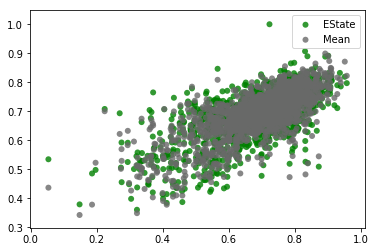

In [ ]:
#plt.scatter(train_on_all['y_test'].values, train_on_all['mean_mg_kg'].values, label="Training set",c="royalblue", edgecolors='none',alpha= 0.8)
#plt.scatter(test_on_all['y_test'].values, test_on_all['test_pred_moe'].values, label="MOE_numer",c="firebrick", edgecolors='none',alpha= 0.8)
#plt.scatter(test_on_all['y_test'].values, test_on_all['test_pred_maccs'].values, label="MACCS",c="slateblue", edgecolors='none',alpha= 0.8)
#plt.scatter(test_on_all['y_test'].values, test_on_all['test_pred_rdkit'].values, label="RDKit_numer",c="deeppink", edgecolors='none',alpha= 0.8)
#plt.scatter(test_on_all['y_test'].values, test_on_all['test_pred_topo'].values, label="Topo",c="goldenrod", edgecolors='none',alpha= 0.8)
plt.scatter(test_on_all['y_test'].values, test_on_all['test_pred_estate'].values, label="EState",c="green", edgecolors='none',alpha= 0.8)
plt.scatter(test_on_all['y_test'].values, test_on_all['mean'].values, label="Mean",c="dimgrey", edgecolors='none',alpha= 0.8)

plt.legend()
plt.show()

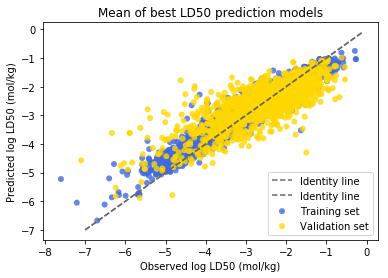

In [ ]:
#plt.plot(np.arange(0,1,0.1), np.arange(0 - np.std(train_on_all['y_train'].values),1- np.std(train_on_all['y_train'].values),0.1), "--", label="x=y minus SD")
#plt.plot(np.arange(0,1,0.1), np.arange(0 + np.std(train_on_all['y_train'].values),1+ np.std(train_on_all['y_train'].values),0.1), "--", label="x=y plus SD")
plt.plot(np.arange(-7,0,0.1), np.arange(-7,0,0.1), "--",label="Identity line", c="dimgrey")
plt.scatter(train_on_all['y_train_mol_kg'].values, train_on_all['mean_mol_kg'].values, label="Training set",c="royalblue", edgecolors='none',alpha= 0.8)
plt.scatter(test_on_all['y_test_mol_kg'].values, test_on_all['mean_mol_kg'].values, label="Validation set",c="gold", edgecolors='none',alpha= 0.8)
plt.xlabel("Observed log LD50 (mol/kg)")
plt.ylabel("Predicted log LD50 (mol/kg)")
plt.title("Mean of best LD50 prediction models")
plt.legend(loc="lower right")
plt.show()

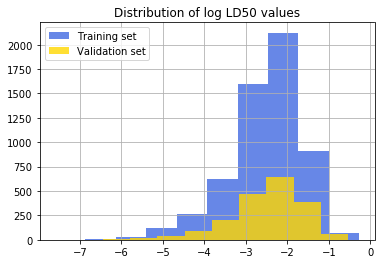

In [ ]:
#train_result['y_train_mg_kg'] = train_result['y_train'].apply(denormalize)
#test_result['y_test_mg_kg'] = test_result['y_test'].apply(denormalize)

#fig = plt.figure()
train_result['y_train_mol_kg'].hist(alpha=0.8, label = "Training set", color = "royalblue")
test_result['y_test_mol_kg'].hist(alpha=0.8, label = "Validation set", color = "gold")
plt.title("Distribution of log LD50 values")
plt.legend()
plt.show()

In [ ]:
train_on_all.to_csv("M:\\ICCVAM\\train_on_all_feb16.csv")
test_on_all.to_csv("M:\\ICCVAM\\test_on_all_feb16.csv")
with_LD50.to_csv("M:\\ICCVAM\\with_LD50_feb16.csv")

In [ ]:
#EState_model = load_model('EState_final_LD50.h5')
#Topological_model = load_model('Topological_final_LD50.h5')
toxprint_fp_model = load_model('toxprint_fp_final_LD50.h5')
rdkit_numeric_param_model = load_model('rdkit_numeric_param_final_LD50.h5')
#MACCS_model = load_model('MACCS_final_LD50.h5')
moe_numeric_param_model = load_model('moe_numeric_param_final_LD50.h5')

In [ ]:
pred = []

In [ ]:
def predict(item, epoch_size, batch_size, optim, hidden_dim, output_fxn, activation, loss_fxn):
    print(item)
    model = None # can load here
    try:
        X_train = np.array(list(with_LD50[item]))
        X_test = np.array(list(data[item])) 

        #Scale X to unit variance and zero mean
        st = StandardScaler()
        try:
            try:
                X_train = st.fit_transform(X_train)
                X_test = st.fit_transform(X_test)
            except:
                reshape = np.reshape(X_train, (-1,1))
                X_train = st.fit_transform(reshape)
                
                reshape = np.reshape(X_test, (-1,1))
                X_test = st.fit_transform(reshape)

            model = Sequential()
            model.add(Dense(input_dim=X_train.shape[1], units=hidden_dim))#units=5))
            #model.add(Dropout (0.2))
            model.add(Activation(activation)) #"relu"
            model.add(Dense(units=1))
            model.add(Activation(output_fxn)) #"linear"
            # add line to stop if loss is negative

            model.compile(loss=loss_fxn, optimizer=optim)
            stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
            reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
            history = model.fit(np.array(X_train), np.array(my_y), epochs=epoch_size, batch_size=batch_size, verbose=1, callbacks=[stop, reduce_lr])

            test_pred = model.predict(X_test)
            train_pred = model.predict(X_train)
            model.save(item+'_final_LD50_feb16_pred.h5')
            model.save_weights(item+'_final_LD50_feb16_weights_pred.h5')

            pred.append((item, test_pred, X_test))
            
        except:
            print('Try reshaping ' + item)
            
    except:
        print('A problem has occurred')

In [ ]:
predict('moe_numeric_param', 2000,42,'Adagrad',245,'sigmoid','softsign','binary_crossentropy')
predict('MACCS', 2000,43,'Adagrad',245,'sigmoid','softsign','binary_crossentropy')
predict('rdkit_numeric_param', 2000,60,'Adadelta',245,'hard_sigmoid','softsign','mean_absolute_error')
predict('toxprint_fp', 2000,46,'SGD',245,'hard_sigmoid','softsign','binary_crossentropy')
predict('Topological', 2000,54, 'SGD',245,'sigmoid','softsign','mean_absolute_error')
predict('EState', 2000,43, 'SGD',245,'hard_sigmoid','softsign','binary_crossentropy')

moe_numeric_param
Epoch 1/2000
7660/7660 [==============================] - 1s 180us/step - loss: 0.6271
Epoch 2/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.6034
Epoch 3/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.6010
Epoch 4/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5995
Epoch 5/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5987
Epoch 6/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5980
Epoch 7/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5975
Epoch 8/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5969
Epoch 9/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5966
Epoch 10/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5960
Epoch 11/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5957
Epoch 12/2000
7660/7660 [========

7660/7660 [==============================] - 0s 64us/step - loss: 0.5876
Epoch 96/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5876
Epoch 97/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5876
Epoch 98/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5876
Epoch 99/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5875
Epoch 100/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5875
Epoch 101/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5875
Epoch 102/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5874
Epoch 103/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5874
Epoch 104/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5874
Epoch 105/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5874
Epoch 106/2000
7660/7660 [=========================

7660/7660 [==============================] - 0s 64us/step - loss: 0.5858
Epoch 189/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5858
Epoch 190/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5858
Epoch 191/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5858
Epoch 192/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5857
Epoch 193/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5857
Epoch 194/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5857
Epoch 195/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5857
Epoch 196/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5857
Epoch 197/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5857
Epoch 198/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5857
Epoch 199/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 282/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 283/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 284/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 285/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 286/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 287/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 288/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 289/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
Epoch 290/2000
7660/7660 [==============================] - 0s 64us/step - loss: 0.5852
MACCS


C:\Users\rsayre01\Continuum\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/2000
7660/7660 [==============================] - 1s 179us/step - loss: 0.6172
Epoch 2/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.6010
Epoch 3/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5987
Epoch 4/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5975
Epoch 5/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5964
Epoch 6/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5957
Epoch 7/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5949
Epoch 8/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5944
Epoch 9/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5938
Epoch 10/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5934
Epoch 11/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5930
Epoch 12/2000
7660/7660 [==========================

7660/7660 [==============================] - 0s 60us/step - loss: 0.5856
Epoch 96/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5856
Epoch 97/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5855
Epoch 98/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5855
Epoch 99/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5855
Epoch 100/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5855
Epoch 101/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5855
Epoch 102/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5854
Epoch 103/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5854
Epoch 104/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5854
Epoch 105/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5854
Epoch 106/2000
7660/7660 [=========================

7660/7660 [==============================] - 0s 60us/step - loss: 0.5846
Epoch 189/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5846
Epoch 190/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5846
Epoch 191/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5846
Epoch 192/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5846
Epoch 193/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5846
Epoch 194/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5846
Epoch 195/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5846
Epoch 196/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5846
Epoch 197/2000
7660/7660 [==============================] - 0s 60us/step - loss: 0.5846
Epoch 198/2000
7660/7660 [==============================] - 0s 61us/step - loss: 0.5846
Epoch 199/2000
7660/7660 [=====================

C:\Users\rsayre01\Continuum\Anaconda3\envs\my-rdkit-env\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Epoch 1/2000
7660/7660 [==============================] - 1s 163us/step - loss: 0.1383
Epoch 2/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0829
Epoch 3/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0774
Epoch 4/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0753
Epoch 5/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0733
Epoch 6/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0724
Epoch 7/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0710
Epoch 8/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0703
Epoch 9/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0692
Epoch 10/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0681
Epoch 11/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0678
Epoch 12/2000
7660/7660 [==========================

7660/7660 [==============================] - 0s 37us/step - loss: 0.0479
Epoch 96/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0477
Epoch 97/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0476
Epoch 98/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0478
Epoch 99/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0475
Epoch 100/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0471
Epoch 101/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0477
Epoch 102/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0468
Epoch 103/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0468
Epoch 104/2000
7660/7660 [==============================] - 0s 38us/step - loss: 0.0469
Epoch 105/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0466
Epoch 106/2000
7660/7660 [=========================

7660/7660 [==============================] - 0s 37us/step - loss: 0.0379
Epoch 189/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0378
Epoch 190/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0378
Epoch 191/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0378
Epoch 192/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0378
Epoch 193/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0377
Epoch 194/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0378
Epoch 195/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0377
Epoch 196/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0377
Epoch 197/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0377
Epoch 198/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0376
Epoch 199/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 37us/step - loss: 0.0363
Epoch 282/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0363
Epoch 283/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0362
Epoch 284/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0363
Epoch 285/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0363
Epoch 286/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0362
Epoch 287/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0362
Epoch 288/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0362
Epoch 289/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0362
Epoch 290/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0362
Epoch 291/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0361
Epoch 292/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 375/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 376/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 377/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 378/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 379/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 380/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 381/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 382/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 383/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 384/2000
7660/7660 [==============================] - 0s 37us/step - loss: 0.0349
Epoch 385/2000
7660/7660 [=====================

7660/7660 [==============================] - 1s 76us/step - loss: 0.5982
Epoch 58/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5981
Epoch 59/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5981
Epoch 60/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5980
Epoch 61/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5980
Epoch 62/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5979
Epoch 63/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5978
Epoch 64/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5978
Epoch 65/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5977
Epoch 66/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5977
Epoch 67/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5976
Epoch 68/2000
7660/7660 [==============================] 

7660/7660 [==============================] - 1s 76us/step - loss: 0.5942
Epoch 151/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5941
Epoch 152/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5941
Epoch 153/2000
7660/7660 [==============================] - 1s 77us/step - loss: 0.5941
Epoch 154/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5940
Epoch 155/2000
7660/7660 [==============================] - 1s 77us/step - loss: 0.5940
Epoch 156/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5940
Epoch 157/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5939
Epoch 158/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5939
Epoch 159/2000
7660/7660 [==============================] - 1s 80us/step - loss: 0.5939
Epoch 160/2000
7660/7660 [==============================] - 1s 77us/step - loss: 0.5938
Epoch 161/2000
7660/7660 [=====================

7660/7660 [==============================] - 1s 76us/step - loss: 0.5914
Epoch 244/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5914
Epoch 245/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5914
Epoch 246/2000
7660/7660 [==============================] - 1s 75us/step - loss: 0.5914
Epoch 247/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5913
Epoch 248/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5913
Epoch 249/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5913
Epoch 250/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5913
Epoch 251/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5912
Epoch 252/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5912
Epoch 253/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5912
Epoch 254/2000
7660/7660 [=====================

7660/7660 [==============================] - 1s 76us/step - loss: 0.5896
Epoch 337/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5896
Epoch 338/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5895
Epoch 339/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5895
Epoch 340/2000
7660/7660 [==============================] - 1s 77us/step - loss: 0.5895
Epoch 341/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5895
Epoch 342/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5895
Epoch 343/2000
7660/7660 [==============================] - 1s 79us/step - loss: 0.5895
Epoch 344/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5894
Epoch 345/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5894
Epoch 346/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5894
Epoch 347/2000
7660/7660 [=====================

7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 430/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 431/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 432/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 433/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 434/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 435/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 436/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5883
Epoch 437/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5882
Epoch 438/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5882
Epoch 439/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5882
Epoch 440/2000
7660/7660 [=====================

7660/7660 [==============================] - 1s 76us/step - loss: 0.5876
Epoch 523/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5876
Epoch 524/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5876
Epoch 525/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5876
Epoch 526/2000
7660/7660 [==============================] - 1s 75us/step - loss: 0.5876
Epoch 527/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5876
Epoch 528/2000
7660/7660 [==============================] - 1s 77us/step - loss: 0.5876
Epoch 529/2000
7660/7660 [==============================] - 1s 75us/step - loss: 0.5876
Epoch 530/2000
7660/7660 [==============================] - 1s 79us/step - loss: 0.5876
Epoch 531/2000
7660/7660 [==============================] - 1s 76us/step - loss: 0.5876
Epoch 532/2000
7660/7660 [==============================] - 1s 77us/step - loss: 0.5876
Epoch 533/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0721
Epoch 58/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0720
Epoch 59/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0720
Epoch 60/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0719
Epoch 61/2000
7660/7660 [==============================] - 0s 33us/step - loss: 0.0718
Epoch 62/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0717
Epoch 63/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0717
Epoch 64/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0716
Epoch 65/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0715
Epoch 66/2000
7660/7660 [==============================] - 0s 33us/step - loss: 0.0715
Epoch 67/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0714
Epoch 68/2000
7660/7660 [==============================] 

7660/7660 [==============================] - 0s 34us/step - loss: 0.0663
Epoch 151/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0663
Epoch 152/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0663
Epoch 153/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0662
Epoch 154/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0661
Epoch 155/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0661
Epoch 156/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0660
Epoch 157/2000
7660/7660 [==============================] - 0s 35us/step - loss: 0.0660
Epoch 158/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0659
Epoch 159/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0658
Epoch 160/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0658
Epoch 161/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0613
Epoch 244/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0613
Epoch 245/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0612
Epoch 246/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0612
Epoch 247/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0611
Epoch 248/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0611
Epoch 249/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0610
Epoch 250/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0610
Epoch 251/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0609
Epoch 252/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0609
Epoch 253/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0609
Epoch 254/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0571
Epoch 337/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0571
Epoch 338/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0570
Epoch 339/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0570
Epoch 340/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0570
Epoch 341/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0569
Epoch 342/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0569
Epoch 343/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0568
Epoch 344/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0568
Epoch 345/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0568
Epoch 346/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0567
Epoch 347/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0539
Epoch 430/2000
7660/7660 [==============================] - 0s 33us/step - loss: 0.0538
Epoch 431/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0538
Epoch 432/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0538
Epoch 433/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0537
Epoch 434/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0537
Epoch 435/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0536
Epoch 436/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0536
Epoch 437/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0536
Epoch 438/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0536
Epoch 439/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0536
Epoch 440/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0512
Epoch 523/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0512
Epoch 524/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0512
Epoch 525/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0511
Epoch 526/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0511
Epoch 527/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0511
Epoch 528/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0511
Epoch 529/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0510
Epoch 530/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0510
Epoch 531/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0510
Epoch 532/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0510
Epoch 533/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 33us/step - loss: 0.0491
Epoch 616/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0491
Epoch 617/2000
7660/7660 [==============================] - 0s 35us/step - loss: 0.0490
Epoch 618/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0490
Epoch 619/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0490
Epoch 620/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0490
Epoch 621/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0490
Epoch 622/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0489
Epoch 623/2000
7660/7660 [==============================] - 0s 33us/step - loss: 0.0489
Epoch 624/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0489
Epoch 625/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0489
Epoch 626/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0472
Epoch 709/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0472
Epoch 710/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0472
Epoch 711/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0472
Epoch 712/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0471
Epoch 713/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0471
Epoch 714/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0471
Epoch 715/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0471
Epoch 716/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0471
Epoch 717/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0470
Epoch 718/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0470
Epoch 719/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0456
Epoch 802/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0456
Epoch 803/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0455
Epoch 804/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0456
Epoch 805/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0455
Epoch 806/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0455
Epoch 807/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0455
Epoch 808/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0455
Epoch 809/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0454
Epoch 810/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0454
Epoch 811/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0454
Epoch 812/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0441
Epoch 895/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0441
Epoch 896/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 897/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0441
Epoch 898/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 899/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 900/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 901/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 902/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 903/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 904/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0440
Epoch 905/2000
7660/7660 [=====================

7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 988/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 989/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 990/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 991/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 992/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 993/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 994/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 995/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
Epoch 996/2000
7660/7660 [==============================] - 0s 34us/step - loss: 0.0430
EState
A problem has occurred


In [ ]:
pred[0]

('moe_numeric_param', array([[ 0.73650432],
        [ 0.73650432],
        [ 0.73650432],
        ..., 
        [ 0.64040536],
        [ 0.66602141],
        [ 0.71505797]], dtype=float32), array([[ 0.77129957, -0.82035397, -0.63658312, ..., -0.01463068,
          0.9203967 ,  0.78629979],
        [ 0.77129957, -0.82035397, -0.63658312, ..., -0.01463068,
          0.9203967 ,  0.78629979],
        [ 0.77129957, -0.82035397, -0.63658312, ..., -0.01463068,
          0.9203967 ,  0.78629979],
        ..., 
        [-0.88724471,  1.21898599,  1.57088676, ..., -0.11368862,
         -0.84498571, -0.95768206],
        [ 0.78059049, -0.82035397, -0.63658312, ..., -0.05364841,
         -0.22471622,  0.10238534],
        [-0.69335362,  1.21898599, -0.63658312, ..., -0.11150228,
         -0.79727268, -0.85509489]]))

In [ ]:
from keras.models import load_model

def predictions(item):
    model_name = item + '_final_LD50.h5'
    model = load_model(model_name)
    try:
        X = np.array(list(data[item]))
        st = StandardScaler()
        try:
            X = st.fit_transform(X)
        except:
            reshape = np.reshape(X, (-1,1))
            X = st.fit_transform(reshape)

        final_pred = model.predict(X)
        pred.append((item, final_pred, X))
        
    except:
        print('too bad')

In [ ]:
lst = ['moe_numeric_param', 'toxprint_fp', 'MACCS', 'rdkit_numeric_param']

for item in lst:
    predictions(item)
pred

C:\Users\rsayre01\Continuum\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rsayre01\Continuum\Anaconda3\envs\my-rdkit-env\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[('moe_numeric_param', array([[ 0.76185399],
         [ 0.76185399],
         [ 0.76185399],
         ..., 
         [ 0.68628651],
         [ 0.69507217],
         [ 0.7283653 ]], dtype=float32), array([[ 0.77129957, -0.82035397, -0.63658312, ..., -0.01463068,
           0.9203967 ,  0.78629979],
         [ 0.77129957, -0.82035397, -0.63658312, ..., -0.01463068,
           0.9203967 ,  0.78629979],
         [ 0.77129957, -0.82035397, -0.63658312, ..., -0.01463068,
           0.9203967 ,  0.78629979],
         ..., 
         [-0.88724471,  1.21898599,  1.57088676, ..., -0.11368862,
          -0.84498571, -0.95768206],
         [ 0.78059049, -0.82035397, -0.63658312, ..., -0.05364841,
          -0.22471622,  0.10238534],
         [-0.69335362,  1.21898599, -0.63658312, ..., -0.11150228,
          -0.79727268, -0.85509489]])),
 ('toxprint_fp', array([[ 0.52502131],
         [ 0.52502131],
         [ 0.52502131],
         ..., 
         [ 0.72161275],
         [ 0.46953228],
         [ 0.

In [ ]:
pred_dict = {}
for i in range(len(pred)):
    #for j in range(len(pred[i][1])):
    pred_dict[pred[i][0] + '_predictions'] = [x[0] for x in pred[i][1]]
    pred_dict[pred[i][0] + '_X'] = [np.mean(x) for x in pred[i][2]]

pred_df = pd.DataFrame.from_dict(pred_dict)
pred_df['mean'] = pred_df.iloc[:,[1,3,5,7]].mean(axis=1)
pred_df['ADI'] = pred_df.iloc[:,[0,2,4,6]].mean(axis=1)
pred_df['mean_mol_kg'] = pred_df['mean'].apply(denormalize)

In [ ]:
pred_df.to_csv("M:\\ICCVAM\\pred_feb16.csv")
data.to_csv("M:\\ICCVAM\\data_pred_feb16.csv")

In [ ]:
from random import shuffle
def y_rand(item, epoch_size, batch_size, optim, hidden_dim, output_fxn, activation, loss_fxn):
    print(item,epoch_size, batch_size, optim, hidden_dim, output_fxn, activation, loss_fxn)
    model = None
    try:
        X_train = np.array(list(X_train_all_fp[item])) #(list(with_LD50[item]))
        X_test = np.array(list(X_test_all_fp[item])) 

        #Scale X to unit variance and zero mean
        st = StandardScaler()
        try:
            try:
                X_train = st.fit_transform(X_train)
                X_test = st.fit_transform(X_test)
            except:
                reshape = np.reshape(X_train, (-1,1))
                X_train = st.fit_transform(reshape)
                
                reshape = np.reshape(X_test, (-1,1))
                X_test = st.fit_transform(reshape)
            
            this_y_train = y_train.copy()
            this_y_test = y_test.copy()
            
            shuffle(this_y_train)
            shuffle(this_y_test)

            model = Sequential()
            model.add(Dense(input_dim=X_train.shape[1], units=hidden_dim))#units=5))
            #    model.add(Dropout (0.2))
            model.add(Activation(activation)) #"relu"
            model.add(Dense(units=1))
            model.add(Activation(output_fxn)) #"linear"
            # add line to stop if loss is negative

            model.compile(loss=loss_fxn, optimizer=optim)#'mean_squared_error', Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
            stop = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto')
            reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
            history = model.fit(np.array(X_train), np.array(this_y_train), epochs=epoch_size, batch_size=batch_size, verbose=1, callbacks=[stop, reduce_lr])

            test_pred = model.predict(X_test)
            train_pred = model.predict(X_train)
            # add constraints model.add(Dense(64, kernel_constraint=max_norm(2.)))
            #http://pubs.acs.org/doi/pdf/10.1021/acs.jcim.6b00088, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4530125/

            rms_test = math.sqrt(metrics.mean_squared_error(this_y_test, test_pred))     # hopefully rms < 0.12196980916781124    
            rms_train = math.sqrt(metrics.mean_squared_error(this_y_train, train_pred))
            q2 = metrics.r2_score(this_y_train, train_pred)
            r2 = metrics.r2_score(this_y_test, test_pred)
            rho = stats.spearmanr(this_y_test, test_pred)
            y_rand_results.append((item, epoch_size, batch_size, optim, hidden_dim,
                                      output_fxn, activation, loss_fxn, rms_test, rms_train, q2, r2,
                                      rho, this_y_train, train_pred, this_y_test, test_pred))
        except:
            print('Try reshaping ' + item)
            
    except:
        duds.append((item, epoch_size, batch_size, optim, hidden_dim,
                              output_fxn, activation, loss_fxn, rms, q2, r2,
                              rho, this_y_train, train_pred, this_y_test, test_pred))

In [ ]:
y_rand_results = []
for item in lst:
    y_rand()

In [ ]:
sweep_total_optim = []
duds = []
epoch_sizes = [100,250,500,1000,1200,1500,2000]#25,50,100,2400]
batch_sizes = [50,75,100,200,300,400,500]#,750,1000] #100,200,300,400,500]
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
hidden_dims = [9, 71, 245, 2517, 5034] # ln(inputs), sqrt(inputs), 2 * math.sqrt((m + 2) * N), half inputs, inputs
activations = ["linear", "softmax", "softplus", "sigmoid", "elu", "selu", "softsign", "relu", "tanh", "hard_sigmoid"]
learning_rates = [0.0001, 0.001, 0.008, 0.01, 0.012, 0.1]
loss_fxns = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','mean_squared_logarithmic_error',
             'squared_hinge','hinge','logcosh','binary_crossentropy','kullback_leibler_divergence','poisson','cosine_proximity']

for e_size in epoch_sizes:
    for b_size in batch_sizes:
        for optimizer in optimizers:
            for hd in hidden_dims:
                for of in activations:
                    for activation in activations:
                        for lf in loss_fxns:
                            sweep_PCA(e_size, b_size, optimizer, hd, of, activation, lf)